### 1. Imports

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.chdir("..")

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
# %pip install lightgbm

In [2]:
# Cellule 1: imports
import pandas as pd
import yaml
from pathlib import Path
from src.models.modeling  import train_models_for_zone



In [4]:
def load_config(config_path: str = "config.yaml") -> dict:
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)
    return cfg

# Cellule 2: configuration
cfg = load_config("config.yaml")
processed_dir = Path(cfg["paths"]["data"]["processed"])
models_dir    = Path("models")
reports_dir   = Path("outputs/reports")
models_dir.mkdir(exist_ok=True, parents=True)
reports_dir.mkdir(exist_ok=True, parents=True)
zones = list(cfg["geo_zones"].values())


In [6]:
# Cellule 3 – Boucle d’entraînement
all_metrics = []
for zone in zones:
    print(f"→ Training {zone}")
    res = train_models_for_zone(zone, processed_dir, models_dir)
    # aplatissement des métriques
    flat = {"zone": zone}
    for h, mets in res.items():
        for m, vals in mets.items():
            flat[f"{h}_{m}_MAE"]  = vals["MAE"]
            flat[f"{h}_{m}_RMSE"] = vals["RMSE"]
            flat[f"{h}_{m}_MAPE"]= vals["MAPE"]
    all_metrics.append(flat)


→ Training Peninsule_Iberique
MAE: 13.90, RMSE: 20.11, MAPE: 0.00%
MAE: 0.00, RMSE: 0.00, MAPE: 0.00%
MAE: 1132250.63, RMSE: 1665226.74, MAPE: 63.14%
MAE: 3465927.15, RMSE: 3562585.43, MAPE: 75.14%
MAE: 8663.81, RMSE: 18867.80, MAPE: inf%
MAE: 8663.81, RMSE: 18867.80, MAPE: inf%
MAE: 7540.52, RMSE: 14661.38, MAPE: 3.94%
→ Training Baleares
MAE: 1138.49, RMSE: 2215.33, MAPE: 37.23%
MAE: 1137.86, RMSE: 2207.92, MAPE: 37.11%
MAE: 1232.48, RMSE: 2685.10, MAPE: 44.44%
MAE: 4901.71, RMSE: 5890.65, MAPE: 113.45%
MAE: 21.94, RMSE: 42.21, MAPE: inf%
MAE: 21.92, RMSE: 42.21, MAPE: inf%
MAE: 13.94, RMSE: 30.29, MAPE: inf%
→ Training Canarias
MAE: 1.51, RMSE: 2.04, MAPE: 0.03%
MAE: 0.00, RMSE: 0.00, MAPE: 0.00%
MAE: 476.85, RMSE: 832.59, MAPE: 2.05%
MAE: 2472.31, RMSE: 4416.50, MAPE: 68.84%
MAE: 29.32, RMSE: 57.90, MAPE: inf%
MAE: 29.17, RMSE: 57.89, MAPE: inf%
MAE: 13.39, RMSE: 36.37, MAPE: inf%
→ Training Gran_canaria
MAE: 589.39, RMSE: 786.02, MAPE: 25.53%
MAE: 616.64, RMSE: 803.67, MAPE: 26.05

In [7]:
# Cellule 4 – Sauvegarde des métriques
pd.DataFrame(all_metrics).to_csv(
    reports_dir/"all_zones_baseline_metrics.csv", index=False
)

In [6]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


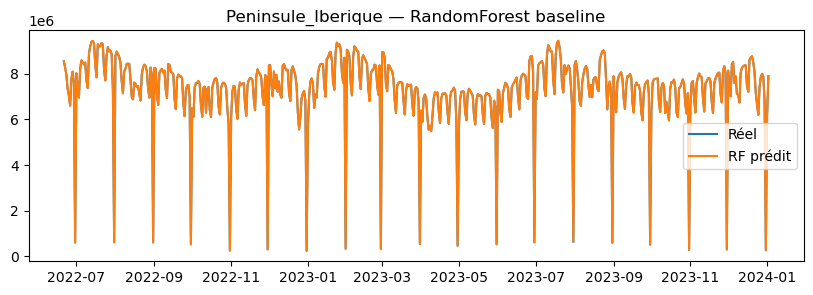

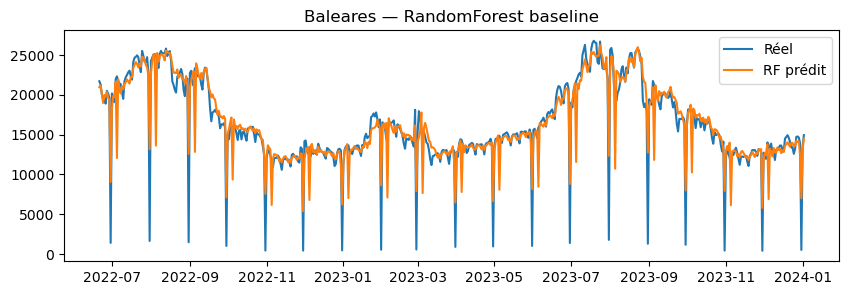

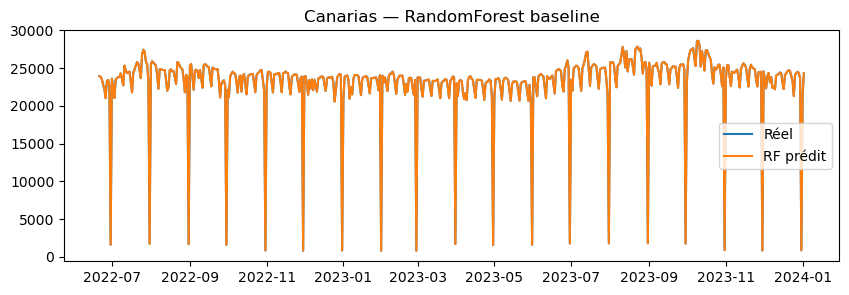

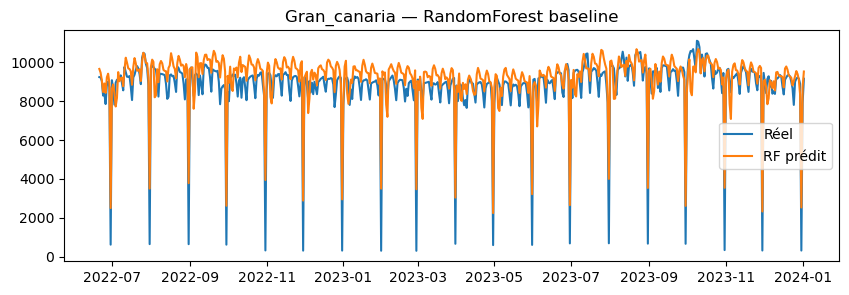

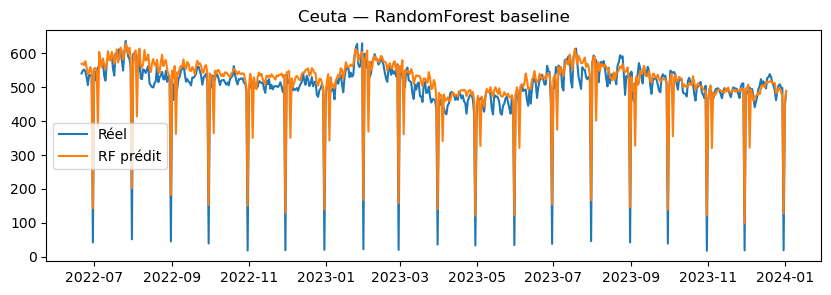

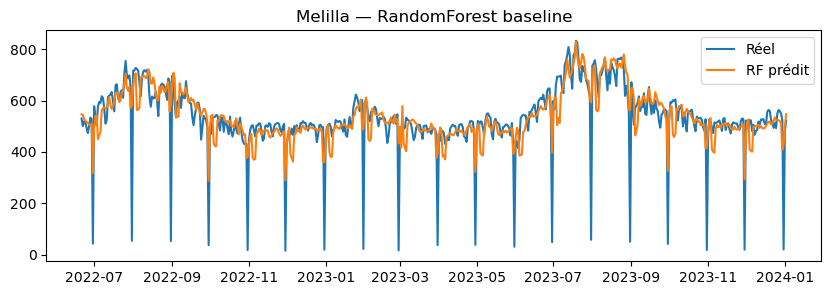

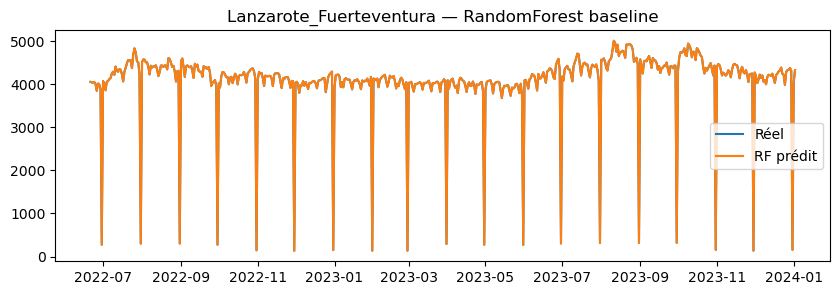

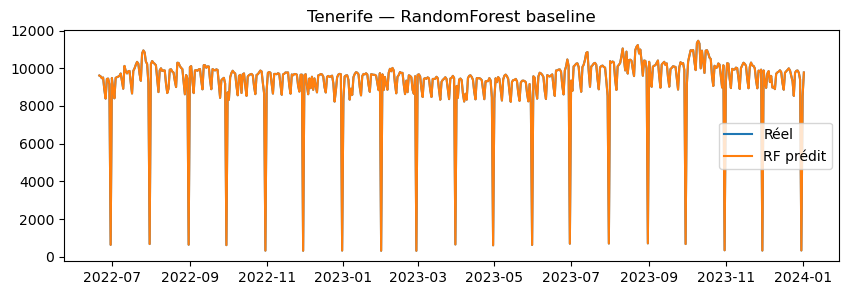

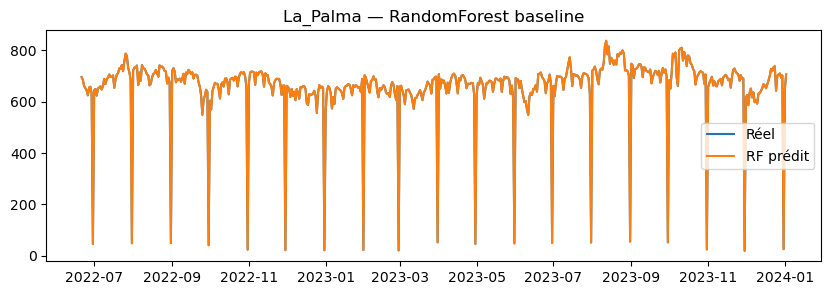

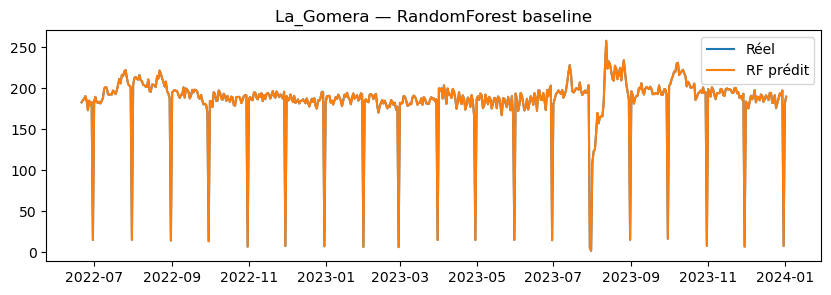

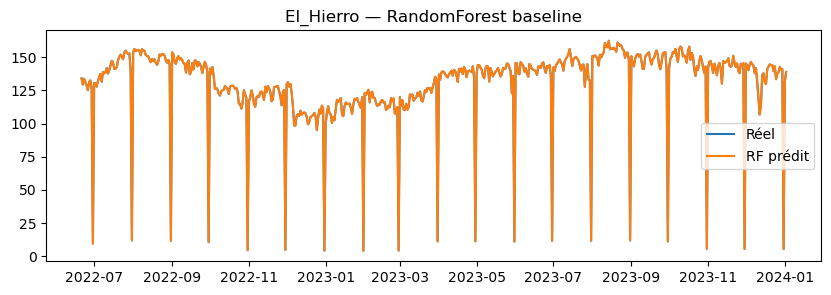

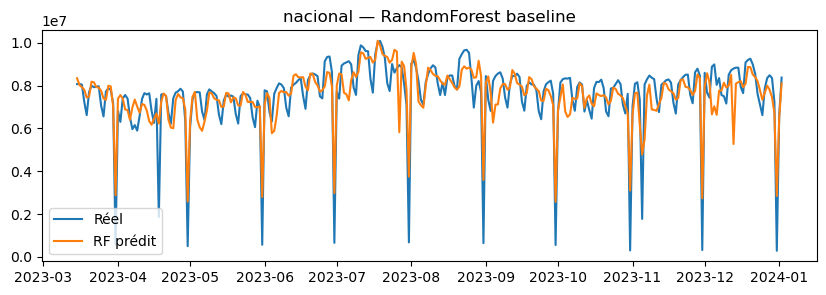

In [9]:
# Cellule 5: visualisation rapide
import matplotlib.pyplot as plt
import joblib

for zone in zones:
    df = pd.read_parquet(processed_dir/f"{zone}_processed_daily.parquet")
    test = df["demand"].iloc[int(len(df)*0.8):]
    model_rf = joblib.load(models_dir/f"{zone}_daily_ridge.pkl")
    pred = model_rf.predict(df.drop(columns="demand").iloc[int(len(df)*0.8):])
    plt.figure(figsize=(10,3))
    plt.plot(test.index, test, label="Réel")
    plt.plot(test.index, pred, label="RF prédit")
    plt.title(f"{zone} — RandomForest baseline")
    plt.legend()
    plt.show()
